It is always nice to start with the data description, which tells us what we are asked to do:

>The goal of this competition is to use seismic signals to predict **the timing of laboratory earthquakes**. The data comes from a well-known experimental set-up used to study earthquake physics. The acoustic_data input signal is used to predict the time remaining before the next laboratory earthquake (time_to_failure).

>The training data is a single, continuous segment of experimental data. The test data consists of a folder containing many small segments. **The data within each test file is continuous, but the test files do not represent a continuous segment of the experiment**; thus, **the predictions cannot be assumed to follow the same regular pattern seen in the training file**.

>For each seg_id in the test folder, **you should predict a single time_to_failure corresponding to the time between the last row of the segment and the next laboratory earthquake**.

The task is relatively straightforward ... to predict the timing of artificial earthquake. 

What is not straightforward is the second paragraph, which implies that **a model trained on the training data might not be useful for a prediction on the test data**.

Anyway let's look at data file first.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train.csv', 'sample_submission.csv']


They are nice enough to give us the sample_submission.csv file.

Also, train is a sigle csv file, whereas test is a folder containing a lot of data.

Next, libraries.

In [2]:
# import libraries
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import spectrogram
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set()

How does the sample_submission.csv look like? 

In [3]:
# check submission file
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission.head()

,time_to_failure
seg_id,
seg_00030f,0
seg_0012b5,0
seg_00184e,0
seg_003339,0
seg_0042cc,0


It looks clean: just 2 columns. The second column is all zero, which we are asked to replace.

How many test files do we have?

In [4]:
PATH = "../input"
print("There are {} files in the test folder".format(len(os.listdir(os.path.join(PATH, "test")))))


There are 2624 files in the test folder


Ah, OK, quite a lot. Let's have a look at 30 of them, which are picked up randomly. I do not have much RAM space (~13 GB), so I spare some by downsampling the data (using every 200 data points).

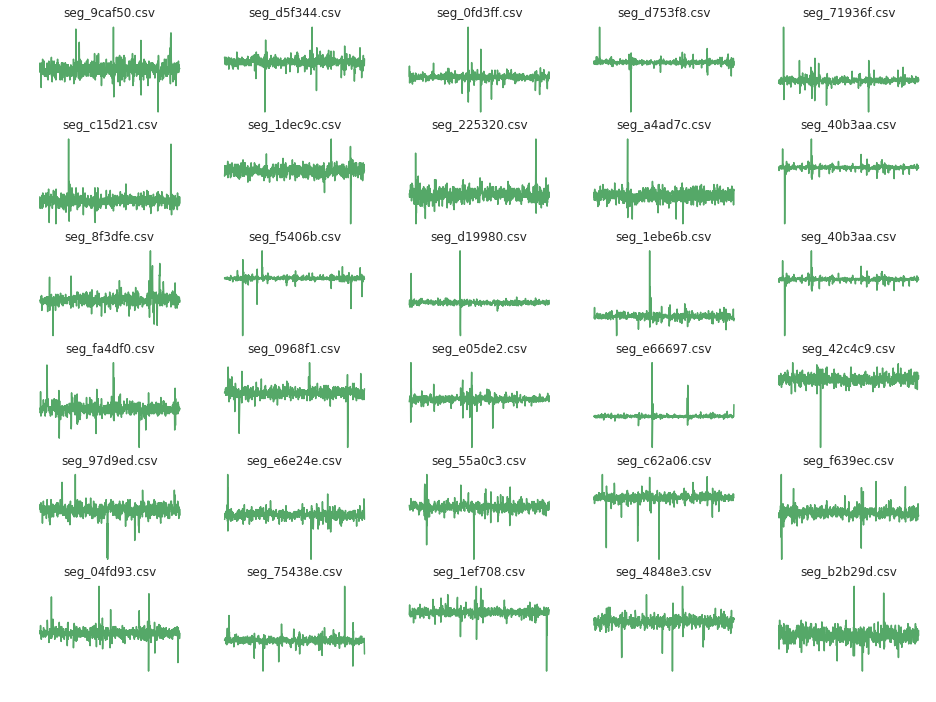

In [5]:
# example 30 test files
tests = os.listdir(os.path.join(PATH, "test"))
n_tests = len(tests)

# downsampling size
ds = 200

# random sampling for test files
N = 30
np.random.seed(1220)
idx = np.random.choice(n_tests, N)

# fig & ax
nrow = int(N/5)
fig, ax = plt.subplots(nrow, 5, figsize=(16, 12))
c = 0
for i in range(nrow):
    for j in range(5):
        # load data
        seg = pd.read_csv(os.path.join(PATH, "test/" + tests[idx[c]]))
        
        # zscore
        seg = stats.zscore(seg)
        
        # plot
        ax[i, j].plot(seg[::ds], color='g')
        ax[i, j].title.set_text(tests[idx[c]])
        ax[i, j].axis("off")
        
        c += 1

Data are quite noisy and variable in terms of signal-to-noise ratio. All I can see is that there are some big spikes occasionally.

How does the train data look like?

In [6]:
%%time
train_df = pd.read_csv(os.path.join(PATH, "train.csv"), 
                       dtype={"acoustic_data": np.int16, 
                              "time_to_failure": np.float32})

CPU times: user 2min 3s, sys: 8.82 s, total: 2min 12s
Wall time: 2min 13s


It takes long time to load the data! Surely you need to specify the data type at least to accelerate the process because ...

In [7]:
print("Train data has {} rows and {} columns"
      .format(train_df.shape[0], train_df.shape[1]))

Train data has 629145480 rows and 2 columns


... the train data contain over 600 million rows. This is huge.

In [8]:
# head 10
pd.options.display.precision = 15
train_df.head(10)

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121
5,8,1.469099998474121
6,9,1.469099998474121
7,7,1.469099998474121
8,-5,1.469099998474121
9,3,1.469099998474121


Yet there are just 2 columns: acoustic_data and time_to_failure. 

How are they related?

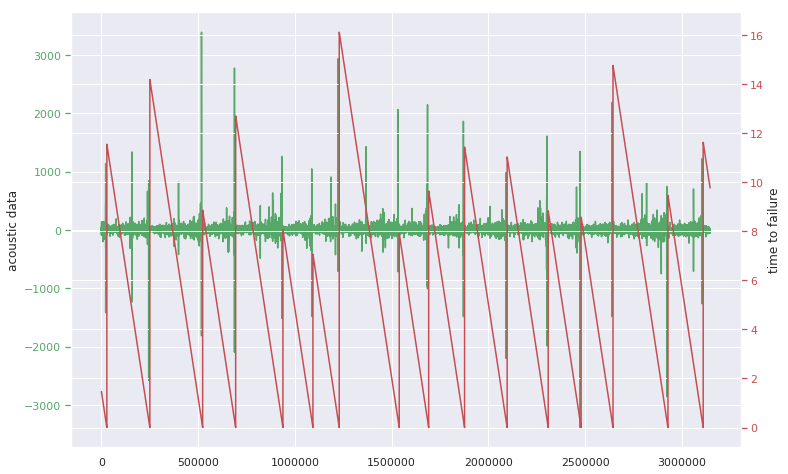

In [9]:
# plot all data, downsampled

# fig & ax
fig, ax1 = plt.subplots(figsize=(12, 8))

# acoustic data
ax1.plot(train_df["acoustic_data"].values[::ds], color='g')
ax1.set_ylabel("acoustic data")
ax1.tick_params('y', colors='g')

# time to failure
ax2 = ax1.twinx()
ax2.plot(train_df["time_to_failure"].values[::ds], color='r')
ax2.set_ylabel("time to failure")
ax2.tick_params('y', colors='r')

Seemingly events (time_to_failure ~= 0) occur after big spikes.

My RAM is almost full already. I downsample the data and remove the original file.

In [10]:
# too heavy to take them anymore
acousticData = train_df["acoustic_data"][::ds].values
timeToFailure = train_df["time_to_failure"][::ds].values

del train_df

Although the data is huge, there seems to be only 16 events, which occur in similar intervals.

In [11]:
# timing (index) of events
sorted_idx = np.argsort(np.diff(timeToFailure))
sorted_idx = sorted_idx[::-1]
eventTiming = np.sort(sorted_idx[0:15])
print("Timing of events: " + str(eventTiming))

Timing of events: [  28282  250429  523386  693862  938209 1229147 1539194 1691381 1876889
 2096844 2309058 2479001 2643885 2927840 3109928]


To see what in acoustic_data drives time_to_failure, the most intuitive way would be an event-triggered analysis: look at acoustic_data around the timing of the events.

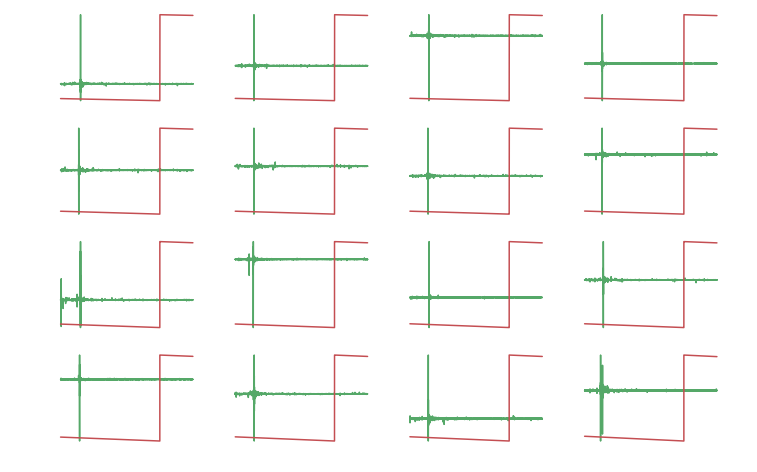

In [12]:
# event triggered average (n = 16)
fig, ax1 = plt.subplots(4, 4, figsize=(12, 8))
c = 0
for i in range(4):
    for j in range(4):
        triggeredRange = range(sorted_idx[c]-int(1500000/ds), sorted_idx[c]+int(500000/ds))

        # acoustic data
        ax1[i, j].plot(acousticData[triggeredRange], color='g')
        ax1[i, j].axis("off")

        # time to failure
        ax2 = ax1[i, j].twinx()
        ax2.plot(timeToFailure[triggeredRange], color='r')
        ax2.axis("off")

        c += 1

This visualization clearly shows that the event is always preceded by a big spike of acoustic_data. The interval between an event and the timing of a big spike looks similar across events. 

Is the amplitude of the spikes (max - min) related to the interval?

Text(0, 0.5, 'time: event - min')

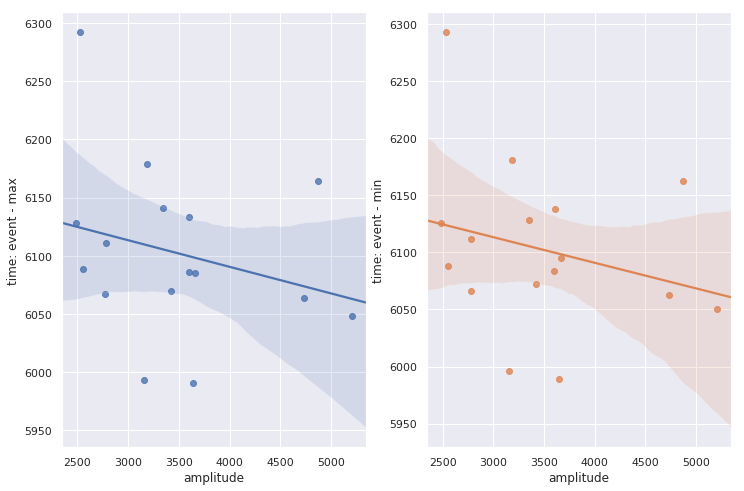

In [13]:
# event amplitude (max - min) vs time to failure from peak
amplitude = np.zeros(16)
max_to_failure = np.zeros(16)
min_to_failure = np.zeros(16)
for c in range(16):
    triggeredRange = range(sorted_idx[c]-int(1500000/ds), sorted_idx[c]+int(500000/ds))
    amplitude[c] = np.max(acousticData[triggeredRange]) - np.min(acousticData[triggeredRange])
    max_to_failure[c] = int(1500000/ds) - np.argmax(acousticData[triggeredRange])
    min_to_failure[c] = int(1500000/ds) - np.argmin(acousticData[triggeredRange])
    
# correlation?
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
sns.regplot(x=amplitude, y=max_to_failure, ax=ax[0])
ax[0].set_xlabel("amplitude")
ax[0].set_ylabel("time: event - max")
sns.regplot(x=amplitude, y=min_to_failure, ax=ax[1])
ax[1].set_xlabel("amplitude")
ax[1].set_ylabel("time: event - min")

Yes, moderately. If the spike is huge, the event is likely to occur soonish. This is intuitive given the experimental setup for earthquake.

In a physical system (like the brain), it is sometimes the case where a particular frequency of the signal tells a lot about the system. Here is the spectrogram of the acoustic_data, where the right end of the x-axis is the timing of the event. 

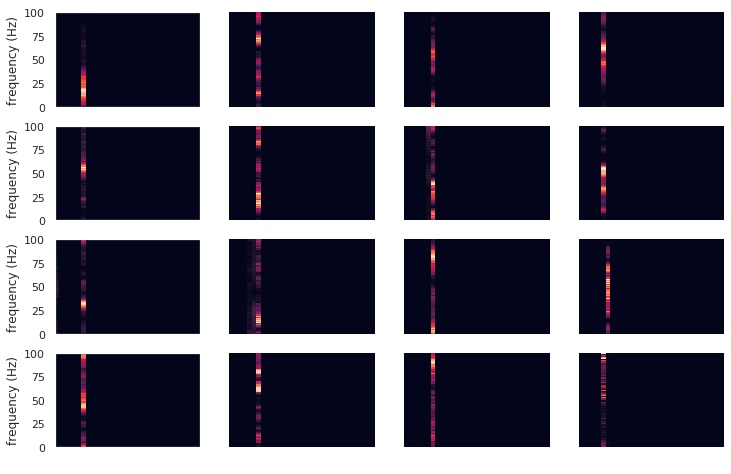

In [14]:
# spectrogram
fig, ax1 = plt.subplots(4, 4, figsize=(12, 8))
c = 0
for i in range(4):
    for j in range(4):
        triggeredRange = range(sorted_idx[c]-int(1500000/ds), sorted_idx[c])

        # FFT of acoustic data
        f, t, Sxx = spectrogram(acousticData[triggeredRange], ds)
        
        # acoustic data
        ax1[i, j].pcolormesh(t, f, Sxx)
        if j == 0:
            ax1[i, j].set_ylabel("frequency (Hz)")
            ax1[i, j].set_xlabel("")
            ax1[i, j].get_xaxis().set_ticks([])
        else:
            ax1[i, j].axis("off")

        c += 1

Those bright areas correspond to the spikes in the signal. Interestingly the distribution of power is variable across events.

The spikes are outliers, so maybe it is more informative to see the signal without the spikes in the power-frequency space by FFT.  

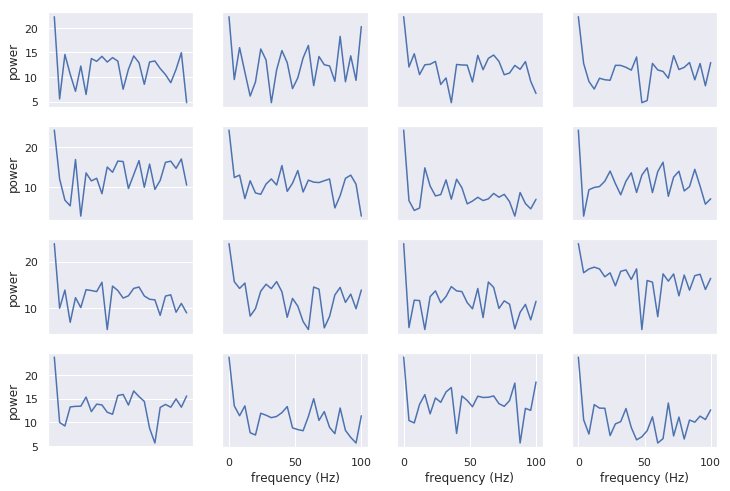

In [21]:
# FFT
fig, ax1 = plt.subplots(4, 4, figsize=(12, 8))
c = 0
for i in range(4):
    for j in range(4):
        triggeredRange = range(sorted_idx[c]-int(10000/ds), sorted_idx[c])

        # FFT of acoustic data
        power = 10*np.log10(np.abs(np.fft.rfft(acousticData[triggeredRange])))
        f = np.linspace(0, ds/2, len(power))
        
        # acoustic data
        ax1[i, j].plot(f, power, c='b')
        if j == 0:
            ax1[i, j].set_ylabel("power")
            ax1[i, j].set_xlabel("")
            ax1[i, j].get_xaxis().set_ticks([])
        elif i == 3:
            ax1[i, j].set_ylabel("")
            ax1[i, j].set_xlabel("frequency (Hz)")
            ax1[i, j].get_yaxis().set_ticks([])
        else:
            ax1[i, j].set_ylabel("")
            ax1[i, j].set_xlabel("")
            ax1[i, j].get_xaxis().set_ticks([])
            ax1[i, j].get_yaxis().set_ticks([])

        c += 1

The exact value of frequency may not be correct, but anyway you see differences in power between frequencies. Those information may be important to predict the time_to_failure.

In conclusion, here in this kernel, some event-triggered analysis were performed to help feature engineering and building a model.